## Business Overview
Starting an organic food delivery service
what is the market like?
Organic food is the fastest-growing category in retail grocery today, but still represents just 6% of the total market share in the U.S. To grow the market, organic trade associations provide coupons and other advertising to incentivize purchases, but currently such promotions are not targeted to individual consumers.

Can likely organic buyers be identified in a way that grows organic sales?

Can we identify users who are likely to buy organic produce based on their past shopping history, combining recommendations from a collaborative filtering model with predictions from a logistic regression model.

The model identifies ___% new likely buyers of organic food and reduces spam to unlikely buyers by 40% compared to not targeting. More focused targeting will increase lift in the percentage of purchases with organic items.

## Data Overview
The dataset is anonymized and contains a sample of over 3 million grocery orders from more than 200,000 Instacart users. For each user, we provide between 4 and 100 of their orders, with the sequence of products purchased in each order.

### orders (3.4m rows, 206k users):

- order_id: order identifier
- user_id: customer identifier
- eval_set: which evaluation set this order belongs in (see SET described below)
- order_number: the order sequence number for this user (1 = first, n = nth)
- order_dow: the day of the week the order was placed on
- order_hour_of_day: the hour of the day the order was placed on
- days_since_prior: days since the last order, capped at 30 (with NAs for order_number = 1)

### products (50k rows):

- product_id: product identifier
- product_name: name of the product
- aisle_id: foreign key
- department_id: foreign key

### aisles (134 rows):

- aisle_id: aisle identifier
- aisle: the name of the aisle

### deptartments (21 rows):

- department_id: department identifier
- department: the name of the department

### order_products__SET (30m+ rows):

- order_id: foreign key
- product_id: foreign key
- add_to_cart_order: order in which each product was added to cart
- reordered: 1 if this product has been ordered by this user in the past, 0 otherwise

where SET is one of the four following evaluation sets (eval_set in orders):

- "prior": orders prior to that users most recent order (~3.2m orders)
- "train": training data supplied to participants (~131k orders)
- "test": test data reserved for machine learning competitions (~75k orders)

In [2]:
#imports
import pandas as pd
import numpy as np
import zipfile
import seaborn as sns
import matplotlib.pyplot as plt
import ray
ray.init()

#from category_encoders import OneHotEncoder

from sklearn.impute import SimpleImputer

from sklearn.model_selection import cross_val_score, train_test_split

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, roc_curve, roc_auc_score, log_loss, precision_score, recall_score, accuracy_score, f1_score

from sklearn.preprocessing import StandardScaler, PolynomialFeatures, normalize, LabelEncoder, MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

2023-08-07 13:57:51,186	INFO worker.py:1621 -- Started a local Ray instance.


In [3]:
#read in files
aisles = pd.read_csv('data/aisles.csv')
departments = pd.read_csv('data/departments.csv')
orders = pd.read_csv('data/orders.csv')
products = pd.read_csv('data/products.csv')
order_products_train = pd.read_csv('data/order_products__train.csv')
order_products_prior = pd.read_csv('data/order_products__prior.csv')
sample_sub = pd.read_csv('data/sample_submission.csv')

In [4]:
table_names = ['aisles','departments','orders','order_products_prior','order_products_train','products','sample_sub']
for i,df in enumerate([aisles,departments,orders,order_products_prior,order_products_train,products,sample_sub]):
    print(table_names[i])
    print(len(df))
    display(df.head())

aisles
134


,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


departments
21


,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


orders
3421083


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


order_products_prior
32434489


,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


order_products_train
1384617


,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


products
49688


,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


sample_sub
75000


,order_id,products
0,17,39276 29259
1,34,39276 29259
2,137,39276 29259
3,182,39276 29259
4,257,39276 29259


In [5]:
print(departments.values)
print(aisles.values)

[[1 'frozen']
 [2 'other']
 [3 'bakery']
 [4 'produce']
 [5 'alcohol']
 [6 'international']
 [7 'beverages']
 [8 'pets']
 [9 'dry goods pasta']
 [10 'bulk']
 [11 'personal care']
 [12 'meat seafood']
 [13 'pantry']
 [14 'breakfast']
 [15 'canned goods']
 [16 'dairy eggs']
 [17 'household']
 [18 'babies']
 [19 'snacks']
 [20 'deli']
 [21 'missing']]
[[1 'prepared soups salads']
 [2 'specialty cheeses']
 [3 'energy granola bars']
 [4 'instant foods']
 [5 'marinades meat preparation']
 [6 'other']
 [7 'packaged meat']
 [8 'bakery desserts']
 [9 'pasta sauce']
 [10 'kitchen supplies']
 [11 'cold flu allergy']
 [12 'fresh pasta']
 [13 'prepared meals']
 [14 'tofu meat alternatives']
 [15 'packaged seafood']
 [16 'fresh herbs']
 [17 'baking ingredients']
 [18 'bulk dried fruits vegetables']
 [19 'oils vinegars']
 [20 'oral hygiene']
 [21 'packaged cheese']
 [22 'hair care']
 [23 'popcorn jerky']
 [24 'fresh fruits']
 [25 'soap']
 [26 'coffee']
 [27 'beers coolers']
 [28 'red wines']
 [29 'ho

In [6]:
#merging files together
df = pd.merge(order_products_prior, products, on='product_id', how='left')
df = pd.merge(df, aisles, on='aisle_id', how='left')
df = pd.merge(df, orders, on='order_id', how='left')
df = pd.merge(df, departments, on='department_id', how='left')

In [8]:
df['product_name'] = df['product_name'].str.lower()

In [9]:
#creating an organic column
df['organic'] = df['product_name'].str.contains('organic').astype(int)

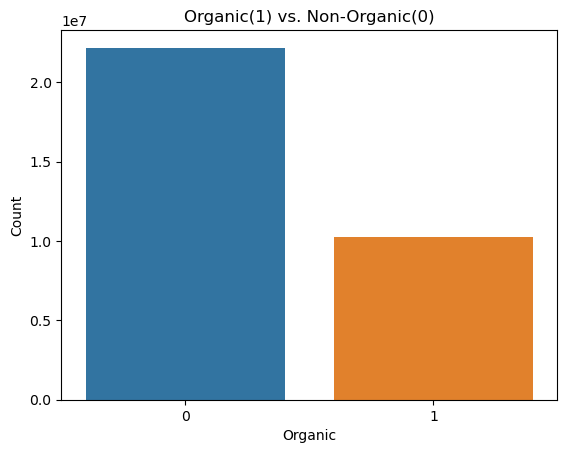

In [10]:
# Create a countplot to visualize the counts of organic and non organic products
sns.countplot(x='organic', data=df)

# Set plot title and axis labels
plt.title('Organic(1) vs. Non-Organic(0)')
plt.xlabel('Organic')
plt.ylabel('Count')

# Show the plot
plt.show()

In [11]:
df['organic'].value_counts()

0    22183774
1    10250715
Name: organic, dtype: int64

In [12]:
#creating an organic produce column
df['organic_produce'] = np.where((df['organic'] == 1) & (df['department'] == 'produce'), 1, 0)

In [13]:
#creating a dataframe of only organic products
organic_df = df[df['organic'] == 1]

In [ ]:
#reordering columns
#organic_df = organic_df[['user_id','order_number','order_id','product_id','add_to_cart_order','reordered','product_name','aisle_id','aisle','department_id','department','order_dow','order_hour_of_day','days_since_prior_order','organic','organic_produce']]

In [14]:
organic_df.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,department,organic,organic_produce
0,2,33120,1,1,organic egg whites,86,16,eggs,202279,prior,3,5,9,8.0,dairy eggs,1,0
1,2,28985,2,1,michigan organic kale,83,4,fresh vegetables,202279,prior,3,5,9,8.0,produce,1,1
12,3,21903,4,1,organic baby spinach,123,4,packaged vegetables fruits,205970,prior,16,5,17,12.0,produce,1,1
14,3,46667,6,1,organic ginger root,83,4,fresh vegetables,205970,prior,16,5,17,12.0,produce,1,1
15,3,17461,7,1,air chilled organic boneless skinless chicken ...,35,12,poultry counter,205970,prior,16,5,17,12.0,meat seafood,1,0


In [16]:
organic_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10250715 entries, 0 to 32434488
Data columns (total 17 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   order_id                int64  
 1   product_id              int64  
 2   add_to_cart_order       int64  
 3   reordered               int64  
 4   product_name            object 
 5   aisle_id                int64  
 6   department_id           int64  
 7   aisle                   object 
 8   user_id                 int64  
 9   eval_set                object 
 10  order_number            int64  
 11  order_dow               int64  
 12  order_hour_of_day       int64  
 13  days_since_prior_order  float64
 14  department              object 
 15  organic                 int32  
 16  organic_produce         int32  
dtypes: float64(1), int32(2), int64(10), object(4)
memory usage: 1.3+ GB


In [27]:
def get_unique_count(x):
    return len(np.unique(x))

customer_cnt = organic_df["user_id"].unique().shape[0]

print(f'We have' ,customer_cnt, 'unique customers in the dataset')


We have 189125 unique customers in the dataset


From this we can see that there are 189,125 unique customers

In [31]:
#Changing the order_dow into days of the weeks
import calendar
days=[]

for i in organic_df['order_dow']:
    days.append(calendar.day_name[i])

#Adding day_of_week column 
organic_df['day_of_week']=days

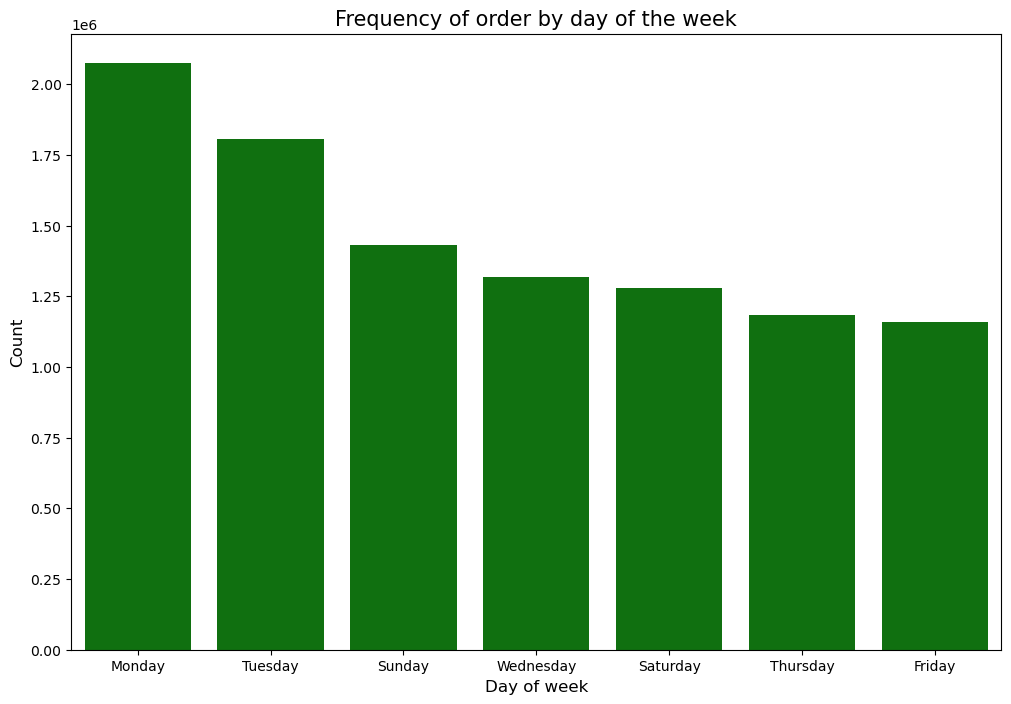

day_of_week
Monday       437701
Tuesday      413446
Wednesday    318359
Sunday       316263
Saturday     304187
Thursday     293270
Friday       284226
Name: order_id, dtype: int64

In [36]:
#plotting to see days with highest activity
plt.figure(figsize=(12,8))

sns.countplot(x="day_of_week", data=organic_df, order=organic_df['day_of_week'].value_counts().index, color='green')

plt.ylabel('Count', fontsize=12)
plt.xlabel('Day of week', fontsize=12)
plt.title("Frequency of order by day of the week", fontsize=15)
plt.show()

dow_count = organic_df.groupby('day_of_week')['order_id'].aggregate(get_unique_count)
dow_count.sort_values(ascending=False)

Can see majority of orders are placed on Monday

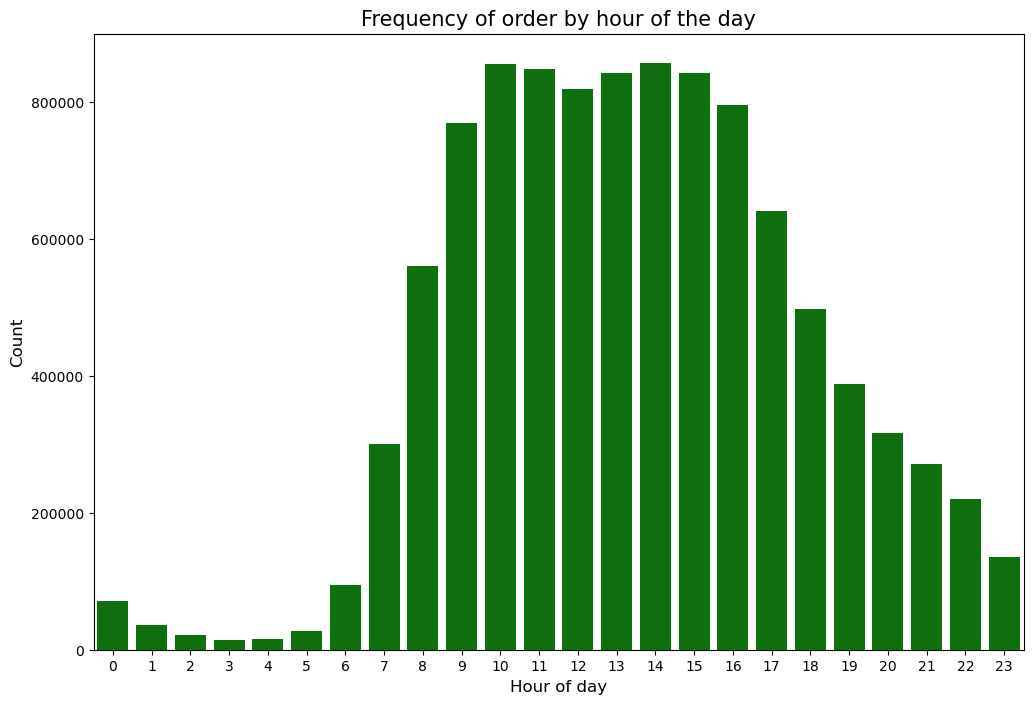

order_hour_of_day
15    197108
10    196574
14    196113
11    194506
13    192391
16    188728
12    187866
9     176884
17    156409
8     126035
18    124350
19     95637
20     72991
7      66424
21     56611
22     45109
23     29020
6      21569
0      16033
1       8432
5       6425
2       4997
4       3636
3       3604
Name: order_id, dtype: int64

In [41]:
#plotting busiest time of day
plt.figure(figsize=(12,8))

sns.countplot(x="order_hour_of_day", data=organic_df, color='green')
plt.ylabel('Count', fontsize=12)
plt.xlabel('Hour of day', fontsize=12)
plt.title("Frequency of order by hour of the day", fontsize=15)
plt.show()

hour_day_count = organic_df.groupby('order_hour_of_day')['order_id'].aggregate(get_unique_count)
hour_day_count.sort_values(ascending=False)

In [43]:
organic_df['is_weekend'] = organic_df['order_dow'].map(lambda d: 1 if d >= 5 else 0)
organic_df['day_period'] = pd.cut(organic_df['order_hour_of_day'], 
                                  bins=[-1, 11, 16, 23], 
                                  labels=['Morning', 'Afternoon', 'Night'], 
                                  include_lowest=True)

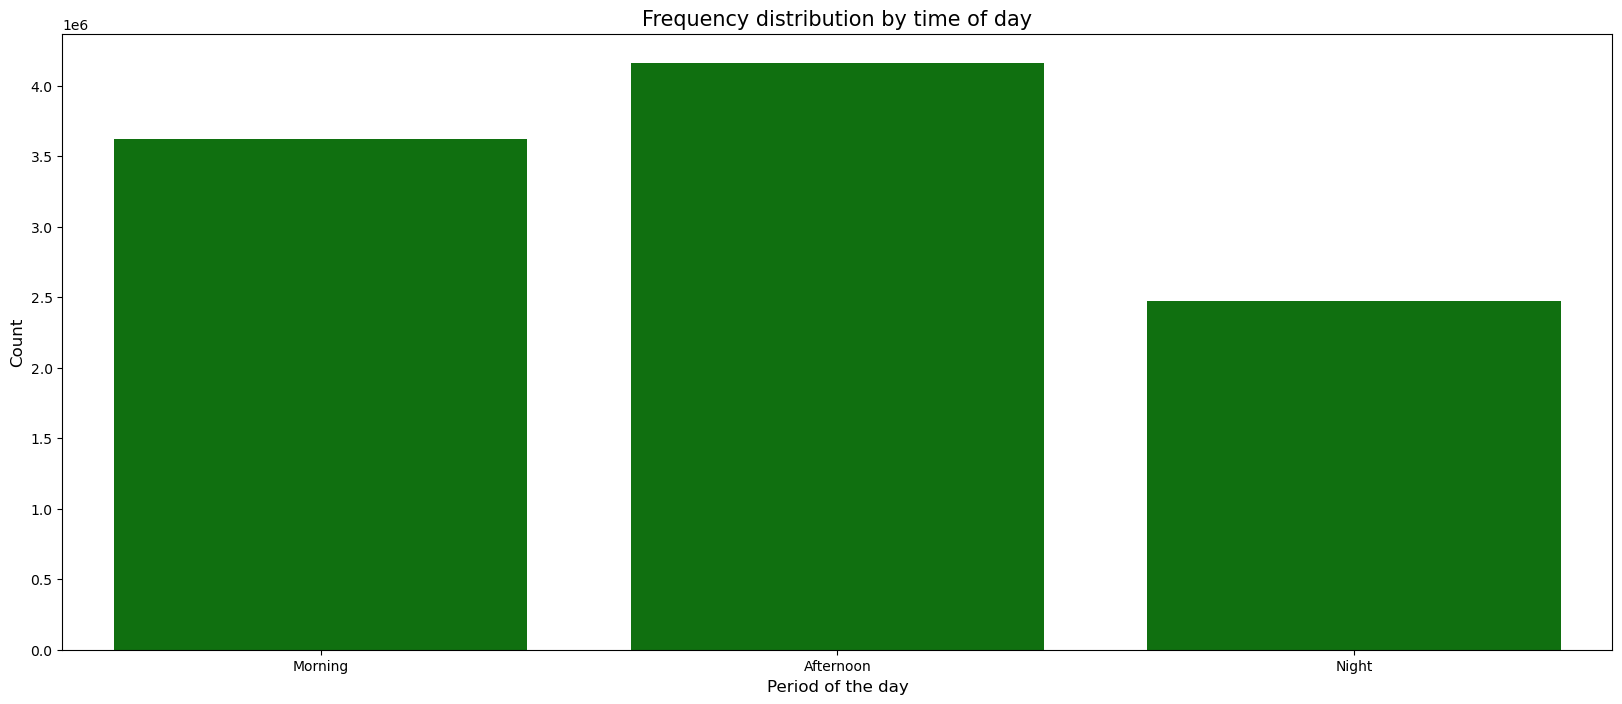

In [46]:
plt.figure(figsize=(20,8))

sns.countplot(x="day_period", data=organic_df, color='green')
plt.ylabel('Count', fontsize=12)
plt.xlabel('Period of the day', fontsize=12)
plt.title("Frequency distribution by time of day", fontsize=15)

plt.show()

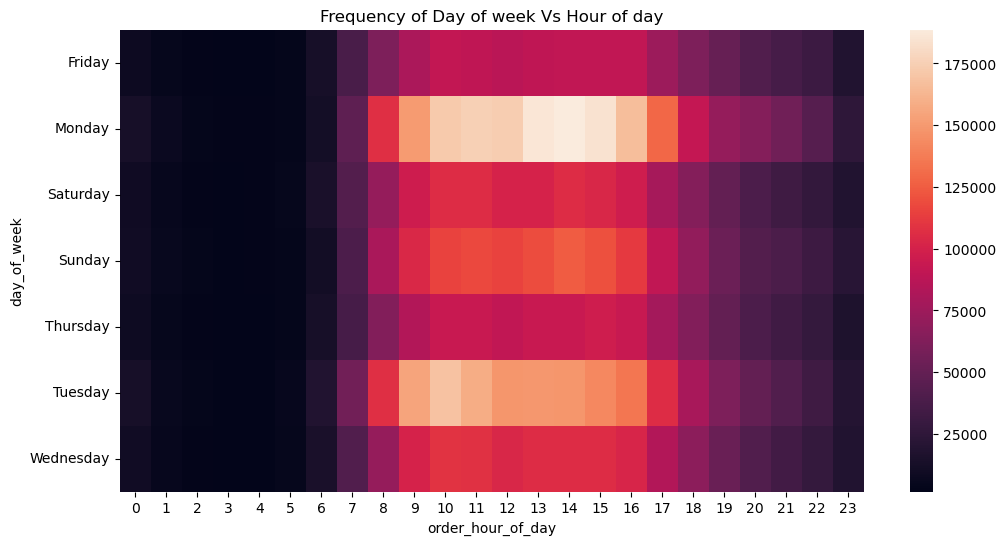

In [39]:
#Heat-map day of week and hour of day
grouped_df = organic_df.groupby(["day_of_week", "order_hour_of_day"])["order_number"].aggregate("count").reset_index()
grouped_df = grouped_df.pivot('day_of_week', 'order_hour_of_day', 'order_number')

plt.figure(figsize=(12,6))
sns.heatmap(grouped_df)
plt.title("Frequency of Day of week Vs Hour of day")
plt.show()

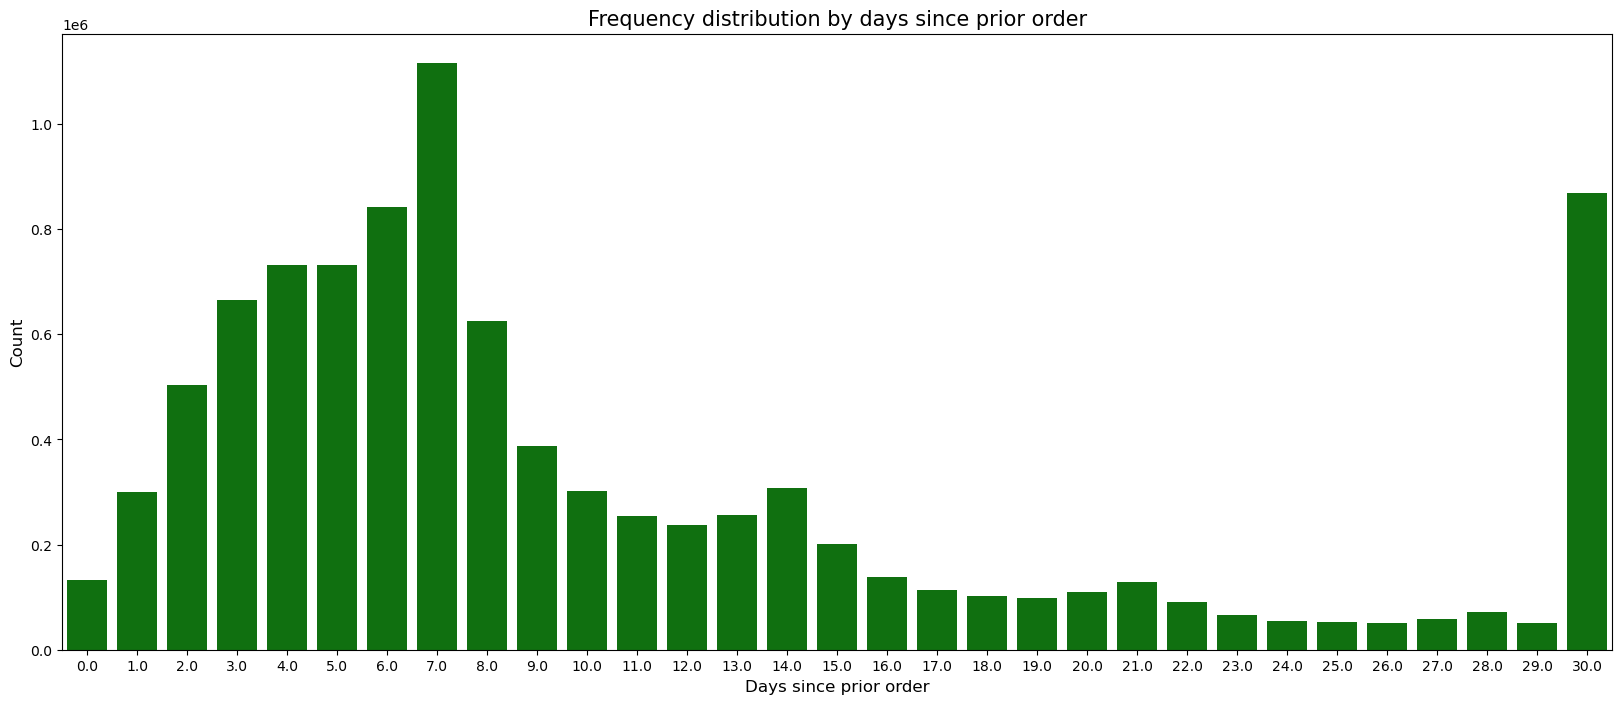

In [42]:
#Finding out after how many days an order is reordered
plt.figure(figsize=(20,8))

sns.countplot(x="days_since_prior_order", data=organic_df, color='green')
plt.ylabel('Count', fontsize=12)
plt.xlabel('Days since prior order', fontsize=12)
plt.title("Frequency distribution by days since prior order", fontsize=15)

plt.show()

We can see that the majority of customers will reorder between 7 days and 30 days

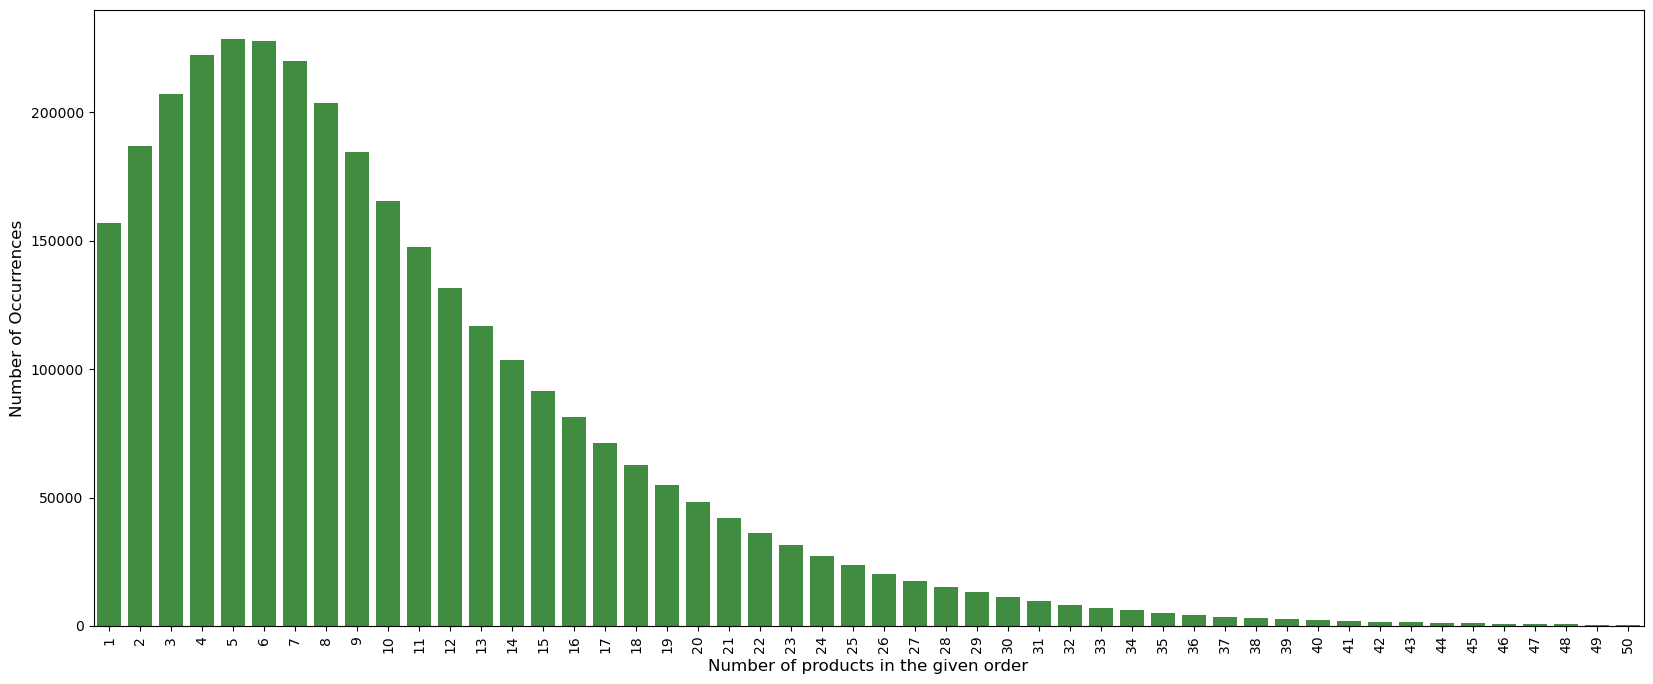

In [56]:
# Group the data by order_id and get the max add_to_cart_order
grouped_df = df.groupby("order_id")["add_to_cart_order"].aggregate("max").reset_index()

# Count the number of orders for each number of products
product_cnt = grouped_df.add_to_cart_order.value_counts().head(50)


plt.figure(figsize=(20, 8))
sns.barplot(x=product_cnt.index, y=product_cnt.values, alpha=0.8, color='green')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Number of products in the given order', fontsize=12)
plt.xticks(rotation='vertical')

plt.show()

In [55]:
df_freq = organic_df['product_name'].value_counts().reset_index().head(20)
df_freq.columns = ['product_name', 'frequency_count']
df_freq

,product_name,frequency_count
0,bag of organic bananas,379450
1,organic strawberries,264683
2,organic baby spinach,241921
3,organic hass avocado,213584
4,organic avocado,176815
5,organic whole milk,137905
6,organic raspberries,137057
7,organic yellow onion,113426
8,organic garlic,109778
9,organic zucchini,104823


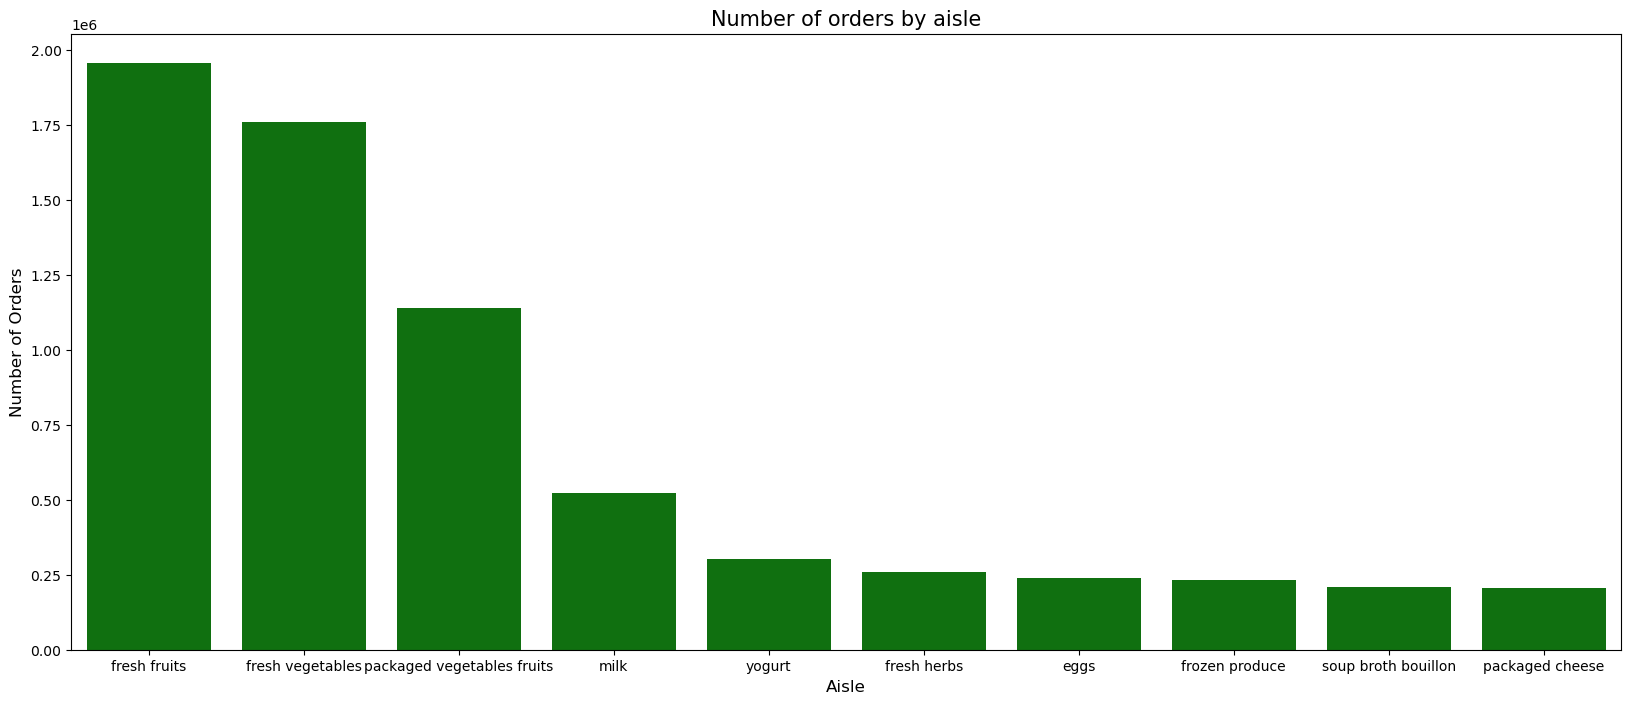

In [61]:
#plotting number of orders by aisle
aisle_cnt = organic_df['aisle'].value_counts().head(10)

plt.figure(figsize=(20,8))

# Create a bar plot of the aisles
sns.barplot(x=aisle_cnt.index, y=aisle_cnt.values, color='green')

# Add a title and labels
plt.ylabel('Number of Orders', fontsize=12)
plt.xlabel('Aisle', fontsize=12)
plt.title("Number of orders by aisle", fontsize=15)

# Show the plot
plt.show()

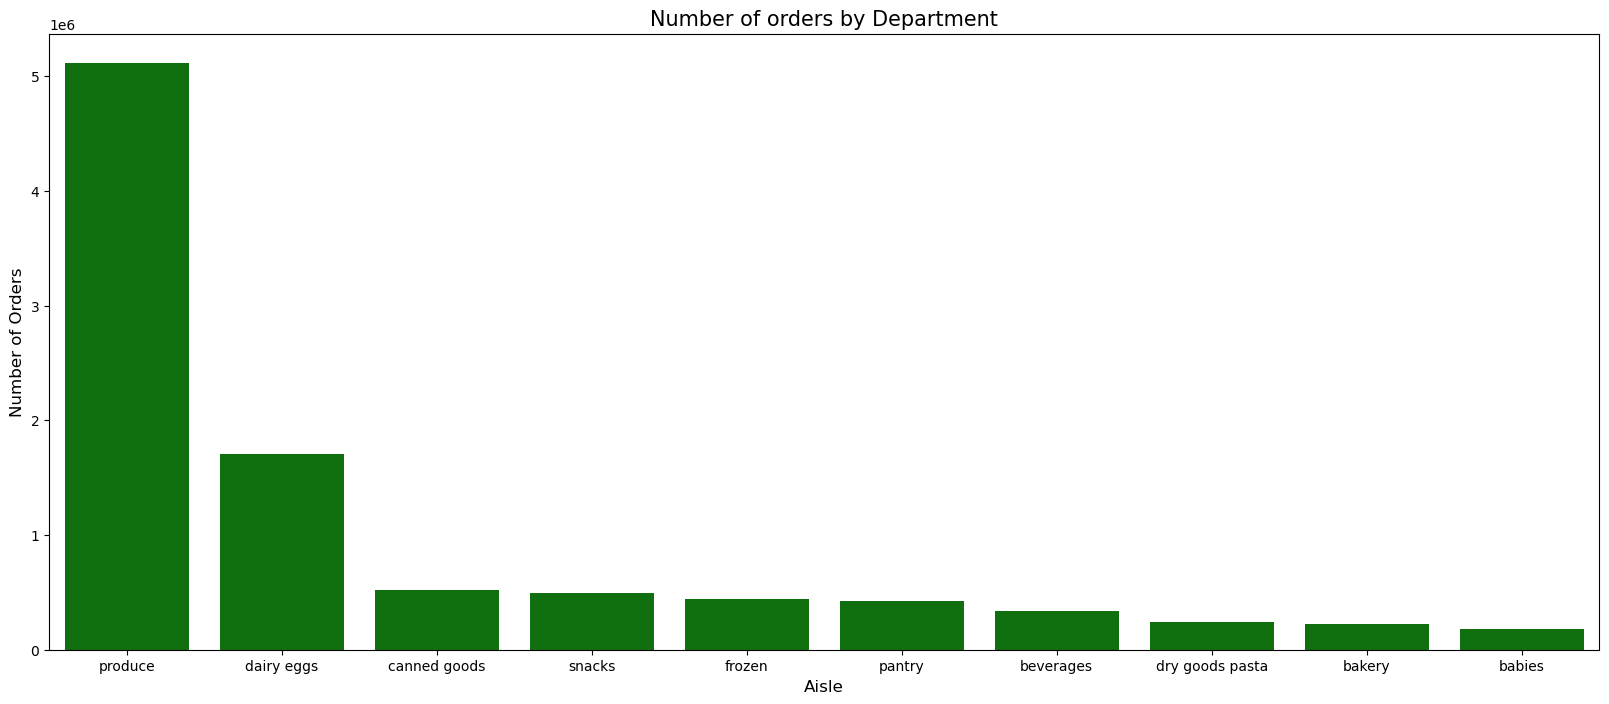

In [63]:
#plotting number of orders by deparment
dept_cnt = organic_df['department'].value_counts().head(10)

plt.figure(figsize=(20,8))

# Create a bar plot of the aisles
sns.barplot(x=dept_cnt.index, y=dept_cnt.values, color='green')

# Add a title and labels
plt.ylabel('Number of Orders', fontsize=12)
plt.xlabel('Aisle', fontsize=12)
plt.title("Number of orders by Department", fontsize=15)

# Show the plot
plt.show()

Seeing a trend in produce being purchased the most

In [69]:
organic_df['organic_produce'].value_counts()

0    5137651
1    5113064
Name: organic_produce, dtype: int64

In [16]:
# Update rows containing 'beef' or 'chicken' in the product name to 'meat seafood'
organic_df.loc[organic_df['product_name'].str.contains('beef|chicken', case=False), 'department'] = 'meat seafood'

# Update rows containing 'yogurt' in the product name to 'dairy eggs'
organic_df.loc[organic_df['product_name'].str.contains('yogurt|heavy cream|cottage cheese|coconut cream|coconut milk|cheddar cheese', case=False), 'department'] = 'dairy eggs'

# Update rows containing 'pasta' in the product name to 'dry goods pasta'
organic_df.loc[organic_df['product_name'].str.contains('pasta|jasmine|brown rice|fettuccine', case=False), 'department'] = 'dry goods pasta'

organic_df.loc[organic_df['product_name'].str.contains('cauliflower|cookie dough', case=False), 'department'] = 'frozen'

organic_df.loc[organic_df['product_name'].str.contains('juice|drink|water|hot chocolate|thirst|almond milk|soy milk|smoothie|kombucha|tonic|tea|Non-Dairy Beverage', case=False), 'department'] = 'beverage'

organic_df.loc[organic_df['product_name'].str.contains('chips|kettle corn|cookies|snack|leather|dippers|chocolate spread|crackers', case=False), 'department'] = 'snacks'

organic_df.loc[organic_df['product_name'].str.contains('bread|corn tortillas', case=False), 'department'] = 'bakery'

organic_df.loc[organic_df['product_name'].str.contains('hummus|spread', case=False), 'department'] = 'deli'

organic_df.loc[organic_df['product_name'].str.contains('cinnamon rolls|Crescent|protein', case=False), 'department'] = 'breakfast'

organic_df.loc[organic_df['product_name'].str.contains('flour|husk|almonds|granola|rice|oats', case=False), 'department'] = 'pantry'

organic_df.loc[organic_df['product_name'].str.contains('babyfood|puree', case=False), 'department'] = 'babies'

In [17]:
produce_name = ['apple','carrot','celery','jicama','salad','cucumber','pepper','kale','peach','squash','mango',
                'lime','beet','kiwi','yam','potato','pear','orange','broccoli','raddish','bunch','eggplant','nectarine',
               'fennel','citrus','kit','sweet corn']
organic_df.loc[organic_df['product_name'].str.contains('|'.join(produce_name), case=False), 'department'] = 'produce'

In [11]:
#organic_df.to_csv('organic_data.csv', index=True)